In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
print("Torch file path:", torch.__file__)


Torch file path: /appl/scibuilder-mamba/aalto-rhel9/prod/software/scicomp-python-env/2025.1/7956747/lib/python3.11/site-packages/torch/__init__.py


In [3]:
import os
os.environ["HF_HOME"] = "/tmp/hf"

In [4]:
import torch
print("CUDA available:", torch.cuda.is_available())
print("GPU count:", torch.cuda.device_count())
if torch.cuda.is_available():
    print("GPU name:", torch.cuda.get_device_name(0))

CUDA available: True
GPU count: 1
GPU name: NVIDIA H100 80GB HBM3


In [5]:
import os
print(os.getcwd())


/home/wangx36/uncertainty-search-compgen-master/uncertainty-search-compgen-master/notebook


In [6]:
import sys
sys.path.append(os.path.abspath("/home/wangx36/uncertainty-search-compgen-master/uncertainty-search-compgen-master"))

In [7]:
import sys
print(sys.executable)


/appl/scibuilder-mamba/aalto-rhel9/prod/software/scicomp-python-env/2025.1/7956747/bin/python


In [8]:
import sys
print(sys.path)

['/appl/scibuilder-mamba/aalto-rhel9/prod/software/scicomp-python-env/2025.1/7956747/lib/python311.zip', '/appl/scibuilder-mamba/aalto-rhel9/prod/software/scicomp-python-env/2025.1/7956747/lib/python3.11', '/appl/scibuilder-mamba/aalto-rhel9/prod/software/scicomp-python-env/2025.1/7956747/lib/python3.11/lib-dynload', '', '/home/wangx36/.local/lib/python3.11/site-packages', '/appl/scibuilder-mamba/aalto-rhel9/prod/software/scicomp-python-env/2025.1/7956747/lib/python3.11/site-packages', '/home/wangx36/uncertainty-search-compgen-master/uncertainty-search-compgen-master']


In [9]:
import sys
sys.path.append("/home/wangx36/.local/lib/python3.11/site-packages")


In [10]:
from uncertainty_search_compgen.data import load_smcalflow_cs_simplified
from uncertainty_search_compgen.load_hf_lm import load_hf_tokenizer
from uncertainty_search_compgen.train_lm import finetune_tf_lm,T5Module
from uncertainty_search_compgen.inference import get_topk_outputs, generate_gpt, uncertainty_guided_search
from uncertainty_search_compgen.dataset import TokenizerPairDataset
from uncertainty_search_compgen.divergence_metrics import (
    measure_entropy,
    measure_mutual_kl_causal_mask,
    measure_teacher_student_model_divergence
)
from uncertainty_search_compgen.plotting import visualize_as_table, plot_batch_and_metric, plot_batch_and_metric_pair

import numpy as np
import torch
from torch.utils.data import DataLoader
import torch.nn.functional as F
from uncertainty_search_compgen.data import format_source, retokenize_input,parse_json_objects


2025-04-25 16:32:03.784463: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-25 16:32:03.796001: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-25 16:32:03.809274: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-25 16:32:03.813045: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-25 16:32:03.823184: I tensorflow/core/platform/cpu_feature_guar

In [11]:
(
    train_pairs,
    train_full,
    val_pairs,
    test_pairs
) = load_smcalflow_cs_simplified(
    "/home/wangx36/uncertainty-search-compgen-master/uncertainty-search-compgen-master/text/semparse/smcalflow-cs"
)


In [12]:
train_pairs[:1]

[('Set up a meeting with Hannah and Sara for next Thursday before 4 pm . ',
  'CreateEvent ( AND ( with _ attendee ( " Hannah " ) , with _ attendee ( " Sara " ) , starts _ at ( OnDateBeforeTime ( date = NextDOW ( " THURSDAY " ) , time = NumberPM ( 4 ) ) ) ) ) ',
  '86f29318-d2a5-4fa0-9fcf-b4840ca75de9.0')]

In [13]:
# Fewshot data
train_full[-128:-126]

[('Set up a meeting for Monday of next week at 3 with Sarah and her boss',
  'CreateEvent ( AND ( with _ attendee ( " Sarah " ) , with _ attendee ( FindManager ( " Sarah " ) ) , starts _ at ( DowOfWeekNew ( dow = DayOfWeek ( " MONDAY " ) , week = NextWeekList ( ) ) ) , starts _ at ( NumberPM ( 3 ) ) ) ) ',
  '7b6fd772-aaab-4015-9519-5b7c3459c2b6.0'),
 ('Make an event for Rob and his manager and invite Chris and his manager as well for next saturday at 1 pm',
  'CreateEvent ( AND ( with _ attendee ( " Rob " ) , with _ attendee ( FindManager ( " Rob " ) ) , with _ attendee ( " Chris " ) , with _ attendee ( FindManager ( " Chris " ) ) , starts _ at ( NextDOW ( " SATURDAY " ) ) , starts _ at ( NumberPM ( 1 ) ) ) ) ',
  '53a1d409-b78f-41b3-b0b7-c914edbf44c6.0')]

In [14]:
test_pairs[:2]

[("Schedule a meeting with Elli and her manager ' s boss tomorrow morning . ",
  'CreateEvent ( AND ( with _ attendee ( " Elli " ) , with _ attendee ( FindManager ( FindManager ( " Elli " ) ) ) , starts _ at ( Morning ( ) ) , starts _ at ( Tomorrow ( ) ) ) ) ',
  'a13ffcd8-86a3-46f0-aeef-4c7f43620152.4'),
 ('create work drinks after meeting with boss',
  'CreateEvent ( AND ( has _ subject ( " work drinks " ) , starts _ at ( : end ( FindEvents ( with _ attendee ( FindManager ( CurrentUser ( ) ) ) ) ) ) ) ) ',
  '84a9c27c-5388-4d72-b23d-a8d97a6e3696.0')]

In [15]:
tokenizer, idx2word = load_hf_tokenizer("Salesforce/codet5p-220m")

In [16]:

# def create_combined_pytorch_dataset(dataset1, dataset2, ratio1=0.5, ratio2=0.5, shuffle=True):

#     import random
#     import pickle
#     from torch.utils.data import Subset, ConcatDataset

#     sample_count1 = int(len(dataset1) * ratio1)
#     sample_count2 = int(len(dataset2) * ratio2)
    

#     indices1 = list(range(len(dataset1)))
#     indices2 = list(range(len(dataset2)))
    

#     if shuffle:
#         random.shuffle(indices1)
#         random.shuffle(indices2)
    
#     selected_indices1 = indices1[:sample_count1]
#     selected_indices2 = indices2[:sample_count2]
    
#     subset1 = Subset(dataset1, selected_indices1)
#     subset2 = Subset(dataset2, selected_indices2)

#     combined_dataset = ConcatDataset([subset1, subset2])
    
#     print(f"from data1 {len(subset1)}")
#     print(f"from data2{len(subset2)}")
#     print(f"combine{len(combined_dataset)}")

#     return combined_dataset




# def load_jsonl(file_path, split_label):
#     with open(file_path) as f:
#         return [{**o, "split": split_label} for o in parse_json_objects(f.readlines())]



# high_loss_samples = load_jsonl('/home/wangx36/uncertainty-search-compgen-master/uncertainty-search-compgen-master/high_loss_dataset.jsonl', 'high_loss')



# def process_data(data):
#         return [
#             (retokenize_input(x["source"]), retokenize_input(x["target"]), x["qid"])
#             for x in data if x["target"] is not None
#         ]



# high_loss_samples = process_data(high_loss_samples)



# train_data_for_temperature_head = create_combined_pytorch_dataset(train_full, high_loss_samples, ratio1=0.1, ratio2=1, shuffle=True)

从数据集1中抽取了2552个样本
从数据集2中抽取了2500个样本
合并后的数据集包含5052个样本


In [17]:
# Note: This trains only the decoder (see transformer_optimizer_config)
#
# You might want to train the encoder as well, but for now, only the decoder.
train_only_trainer, train_only_model, train_only_harness = finetune_tf_lm(
    "Salesforce/codet5p-220m",
    tokenizer,
    train_pairs[:-128],
    train_data_for_temperature_head,
    val_pairs,
    root_dir="logs/train_only"
)

Seed set to 0


...

results of the gradient checking:
ATShead gradient status:
warn: layers.0.self_attn.in_proj_weight no gradient
warn: layers.0.self_attn.in_proj_bias no gradient
warn: layers.0.self_attn.out_proj.weight no gradient
warn: layers.0.self_attn.out_proj.bias no gradient
warn: layers.0.linear1.weight no gradient
warn: layers.0.linear1.bias no gradient
warn: layers.0.linear2.weight no gradient
warn: layers.0.linear2.bias no gradient
warn: layers.0.norm1.weight no gradient
warn: layers.0.norm1.bias no gradient
warn: layers.0.norm2.weight no gradient
warn: layers.0.norm2.bias no gradient
warn: layers.1.self_attn.in_proj_weight no gradient
warn: layers.1.self_attn.in_proj_bias no gradient
warn: layers.1.self_attn.out_proj.weight no gradient
warn: layers.1.self_attn.out_proj.bias no gradient
warn: layers.1.linear1.weight no gradient
warn: layers.1.linear1.bias no gradient
warn: layers.1.linear2.weight no gradient
warn: layers.1.linear2.bias no gradient
warn: layers.1.norm1.weight no gradient


/appl/scibuilder-mamba/aalto-rhel9/prod/software/scicomp-python-env/2024-01/f56a564/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /appl/scibuilder-mamba/aalto-rhel9/prod/software/sci ...
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
2025-03-07 02:27:16.704407: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-07 02:27:16.704437: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has alr

Sanity Checking: |                                                                                | 0/? [00:00…

/appl/scibuilder-mamba/aalto-rhel9/prod/software/scicomp-python-env/2024-01/f56a564/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/appl/scibuilder-mamba/aalto-rhel9/prod/software/scicomp-python-env/2024-01/f56a564/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |                                                                                       | 0/? [00:00…

/appl/scibuilder-mamba/aalto-rhel9/prod/software/scicomp-python-env/2024-01/f56a564/lib/python3.11/site-packages/pytorch_lightning/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type                       | Params
--------------------------------------------------------
0 | model    | T5ForConditionalGeneration | 222 M 
1 | ats_head | ATShead                    | 14.2 M
--------------------------------------------------------
14.2 M    Trainable params
222 M     Non-trainable params
237 M     Total params
948.234   Total estimated model params size (MB)


Sanity Checking: |                                                                                | 0/? [00:00…

Training: |                                                                                       | 0/? [00:00…

In [41]:
shot_trainer, shot_model, shot_harness = finetune_tf_lm(
    "Salesforce/codet5p-220m",
    tokenizer,
    train_pairs[:-72],# First 32 pairs
    train_data_for_temperature_head,
    val_pairs,
    root_dir="logs/shot_train"
)

Seed set to 0
/appl/scibuilder-mamba/aalto-rhel9/prod/software/scicomp-python-env/2024-01/f56a564/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


...

results of the gradient checking:
ATShead gradient status:
warn: layers.0.self_attn.in_proj_weight no gradient
warn: layers.0.self_attn.in_proj_bias no gradient
warn: layers.0.self_attn.out_proj.weight no gradient
warn: layers.0.self_attn.out_proj.bias no gradient
warn: layers.0.linear1.weight no gradient
warn: layers.0.linear1.bias no gradient
warn: layers.0.linear2.weight no gradient
warn: layers.0.linear2.bias no gradient
warn: layers.0.norm1.weight no gradient
warn: layers.0.norm1.bias no gradient
warn: layers.0.norm2.weight no gradient
warn: layers.0.norm2.bias no gradient
warn: layers.1.self_attn.in_proj_weight no gradient
warn: layers.1.self_attn.in_proj_bias no gradient
warn: layers.1.self_attn.out_proj.weight no gradient
warn: layers.1.self_attn.out_proj.bias no gradient
warn: layers.1.linear1.weight no gradient
warn: layers.1.linear1.bias no gradient
warn: layers.1.linear2.weight no gradient
warn: layers.1.linear2.bias no gradient
warn: layers.1.norm1.weight no gradient


Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type                       | Params
--------------------------------------------------------
0 | model    | T5ForConditionalGeneration | 222 M 
1 | ats_head | ATShead                    | 14.2 M
--------------------------------------------------------
222 M     Trainable params
14.2 M    Non-trainable params
237 M     Total params
948.234   Total estimated model params size (MB)


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=2500` reached.
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type                       | Params
--------------------------------------------------------
0 | model    | T5ForConditionalGeneration | 222 M 
1 | ats_head | ATShead                    | 14.2 M
--------------------------------------------------------
14.2 M    Trainable params
222 M     Non-trainable params
237 M     Total params
948.234   Total estimated model params size (MB)


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=2500` reached.


In [16]:
# 重用已有的trainer和model
shot_trainer, shot_model, shot_harness = finetune_tf_lm(
    "Salesforce/codet5p-220m",
    tokenizer,
    train_pairs[:-72],
    train_full,
    val_pairs,
    load_from="logs/shot_train/stage2/final_model_with_new_tempurature_stage2.ckpt",  # 加载保存的模型
    do_fit=False  # 不重新训练
)

Seed set to 0
/appl/scibuilder-mamba/aalto-rhel9/prod/software/scicomp-python-env/2025.1/7956747/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:817: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(
/home/wangx36/uncertainty-search-compgen-master/uncertainty-search-compgen-master/uncertainty_search_compgen/train_lm.py:611: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitra

In [17]:
train_only_trainer, train_only_model, train_only_harness = finetune_tf_lm(
    "Salesforce/codet5p-220m",
    tokenizer,
    train_pairs[:-128],
    train_full,
    val_pairs,
    load_from="logs/train_only/stage2/final_model_with_new_tempurature_stage2.ckpt",  # 加载training only的模型
    do_fit=False  # 不重新训练
)

Seed set to 0
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [16]:
# train_only_trainer, train_only_model1, train_only_harness = finetune_tf_lm(
#     "Salesforce/codet5p-220m",
#     tokenizer,
#     train_pairs[:-128],
#     train_full,
#     val_pairs,
#     load_from="logs/train_only/stage1/final_model_for_generate_data.ckpt",  # 加载training only的模型
#     do_fit=False  # 不重新训练
# )

Seed set to 0


config.json:   0%|          | 0.00/768 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/446M [00:00<?, ?B/s]

/appl/scibuilder-mamba/aalto-rhel9/prod/software/scicomp-python-env/2025.1/7956747/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:817: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(
/home/wangx36/uncertainty-search-compgen-master/uncertainty-search-compgen-master/uncertainty_search_compgen/train_lm.py:669: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects wil

In [51]:
# def compute_final_high_loss_samples(model, dataloader, pad_token, top_ratio, device, output_file='high_loss_qids1.txt'):
#     import torch.nn.functional as F
    
#     loss_dict = {}
#     qid_dict = {}  # 存储sample_id到qid的映射
    
#     with torch.no_grad():
#         for batch_idx, batch in enumerate(dataloader):
#             # 确保模型在正确的设备上
#             model = model.to(device)
            
#             # 创建一个新的batch字典，所有张量都移动到正确的设备
#             device_batch = {}
#             for k, v in batch.items():
#                 if isinstance(v, torch.Tensor):
#                     device_batch[k] = v.to(device)
#                 else:
#                     device_batch[k] = v
            
#             # 存储当前批次的qid
#             if 'qid' in batch:
#                 for i, qid in enumerate(batch['qid']):
#                     sample_id = batch_idx * dataloader.batch_size + i
#                     qid_dict[sample_id] = qid
            
#             # 使用device_batch进行模型操作
#             outputs = model(
#                 input_ids=device_batch["input_ids"],
#                 attention_mask=device_batch.get("attention_mask", None),
#                 decoder_input_ids=device_batch.get("decoder_input_ids", None),
#                 decoder_attention_mask=device_batch.get("decoder_attention_mask", None),
#                 labels=device_batch.get("labels", None),
#             )
            
#             # 获取预测结果
#             preds = outputs.logits
            
#             # 计算token级别的损失（忽略pad tokens）
#             token_losses = F.cross_entropy(
#                 preds.view(-1, preds.size(-1)),
#                 device_batch["labels"].view(-1),
#                 reduction='none',
#                 ignore_index=pad_token
#             ).view(preds.shape[0], -1)
            
#             # 存储batch_idx和计算的损失
#             for i in range(batch["input_ids"].shape[0]):
#                 sample_id = batch_idx * dataloader.batch_size + i
#                 loss_dict[sample_id] = token_losses[i].mean().item()
    
#     # 找出高损失样本
#     sorted_losses = sorted(loss_dict.items(), key=lambda x: x[1], reverse=True)
#     num_high_loss = int(len(sorted_losses) * top_ratio)
#     high_loss_samples = [idx for idx, _ in sorted_losses[:num_high_loss]]
    
#     # 收集高损失样本的qid
#     high_loss_qids = []
#     for idx in high_loss_samples:
#         if idx in qid_dict:
#             high_loss_qids.append(qid_dict[idx])
#         else:
#             high_loss_qids.append(str(idx))  # 如果没有qid，使用索引作为标识
    
#     # 将qids保存到文件
#     with open(output_file, 'w') as f:
#         for qid in high_loss_qids:
#             f.write(f"{qid}\n")
    
#     print(f"已将{len(high_loss_qids)}个高损失样本的qid保存到 {output_file}")
    
#     return high_loss_samples, high_loss_qids

In [52]:
# dataset1 = TokenizerPairDataset(train_full[-128:], tokenizer)

In [53]:
# train_dataloader = DataLoader(
#     dataset1,
#     batch_size=32,
#     shuffle=False,
# )

In [54]:
# import torch
# compute_final_high_loss_samples(train_only_model1, dataloader=train_dataloader, pad_token=tokenizer.pad_token_id, top_ratio=0.1, device="cuda")

已将12个高损失样本的qid保存到 high_loss_qids1.txt


([106, 94, 110, 86, 105, 125, 53, 39, 124, 50, 111, 36],
 ['b58fb1c2-5858-4aea-9061-6f9218cffce2.1',
  '5dfbd4c8-c451-4a0f-b331-6de92fdd4237.0',
  '20969fb1-db47-4282-957d-fbf74b3c50ba.1',
  'f8893bfd-ef71-4c9e-9307-17069292795d.2',
  '4c88ca0d-c6d0-493f-bbe6-b227430e7d6a.0',
  'eb3ea4b2-b5b6-416a-86e5-08981c2f8df4.0',
  'cc994e8f-7508-479f-8422-9620dd662969.2',
  'bd667849-51f1-438f-94b4-d68b7a7eada7.0',
  '5da058cf-53ea-4355-a841-2ee1dcea5125.0',
  '08705eda-ffbc-4afb-b788-a67fe878b906.0',
  'fad08b6b-a76a-4259-a7d8-5dabf2c2113e.1',
  '5cc6e434-fe04-4149-8f49-4bf3582d2717.0'])

In [55]:
# def create_high_loss_dataset_from_qids(original_dataset_file, high_loss_qids_file, output_file):
#     """
#     根据高损失样本的qid文件从原始数据集中提取样本，创建一个新的数据集
    
#     参数:
#     original_dataset_file: 原始数据集的文件路径（JSONL格式）
#     high_loss_qids_file: 包含高损失样本qid的文件路径
#     output_file: 输出新数据集的文件路径
    
#     返回:
#     high_loss_samples_count: 提取的高损失样本数量
#     """
#     import json
    
#     # 读取高损失样本的qid
#     with open(high_loss_qids_file, 'r') as f:
#         high_loss_qids = set([line.strip() for line in f])
    
#     print(f"读取了{len(high_loss_qids)}个高损失样本的qid")
    
#     # 从原始数据集中提取高损失样本
#     high_loss_samples = []
    
#     with open(original_dataset_file, 'r', encoding='utf-8') as f:
#         for line in f:
#             if not line.strip():
#                 continue
            
#             try:
#                 sample = json.loads(line.strip())
#                 if sample.get('qid') in high_loss_qids:
#                     high_loss_samples.append(sample)
#             except json.JSONDecodeError:
#                 print(f"警告: 跳过无效的JSON行: {line[:50]}...")
    
#     print(f"从原始数据集中提取了{len(high_loss_samples)}个高损失样本")
    
#     # 保存新数据集
#     with open(output_file, 'w', encoding='utf-8') as f:
#         for sample in high_loss_samples:
#             f.write(json.dumps(sample, ensure_ascii=False) + '\n')
    
#     print(f"高损失样本数据集已保存到 {output_file}")
    
#     return len(high_loss_samples)

In [58]:
# create_high_loss_dataset_from_qids(
#     original_dataset_file="/home/wangx36/uncertainty-search-compgen-master/uncertainty-search-compgen-master/text/semparse/smcalflow-cs/train.simplified.jsonl",
#     high_loss_qids_file="high_loss_qids1.txt",
#     output_file="high_loss_dataset1.jsonl"
# )

读取了12个高损失样本的qid
从原始数据集中提取了0个高损失样本
高损失样本数据集已保存到 high_loss_dataset1.jsonl


0

In [75]:
# def create_combined_pytorch_dataset(dataset1, dataset2, ratio1=0.5, ratio2=0.5, shuffle=True,json_path=None):
#     """
#     从两个PyTorch数据集中按指定比例抽取样本，组成一个新的数据集
    
#     参数:
#     dataset1: 第一个PyTorch数据集
#     dataset2: 第二个PyTorch数据集
#     ratio1: 从第一个数据集中抽取的比例（默认0.5，即50%）
#     ratio2: 从第二个数据集中抽取的比例（默认0.5，即50%）
#     shuffle: 是否打乱样本顺序（默认True）
    
#     返回:
#     combined_dataset: 合并后的PyTorch数据集
#     """
#     import random
#     import pickle
#     from torch.utils.data import Subset, ConcatDataset
    
#     # 计算要抽取的样本数量
#     sample_count1 = int(len(dataset1) * ratio1)
#     sample_count2 = int(len(dataset2) * ratio2)
    
#     # 生成索引列表
#     indices1 = list(range(len(dataset1)))
#     indices2 = list(range(len(dataset2)))
    
#     # 随机打乱索引（如果需要）
#     if shuffle:
#         random.shuffle(indices1)
#         random.shuffle(indices2)
    
#     # 抽取子集
#     selected_indices1 = indices1[:sample_count1]
#     selected_indices2 = indices2[:sample_count2]
    
#     subset1 = Subset(dataset1, selected_indices1)
#     subset2 = Subset(dataset2, selected_indices2)
    
#     # 合并数据集
#     combined_dataset = ConcatDataset([subset1, subset2])
    
#     print(f"从数据集1中抽取了{len(subset1)}个样本")
#     print(f"从数据集2中抽取了{len(subset2)}个样本")
#     print(f"合并后的数据集包含{len(combined_dataset)}个样本")
#     if json_path:
#         # 使用pickle保存原始数据
#         with open(json_path, 'wb') as f:
#             pickle.dump(combined_dataset, f)
        
#         print(f"数据集已保存到: {json_path}")
#         print(combined_dataset[:2])
#     return combined_dataset

In [76]:

    # def load_jsonl(file_path, split_label):
    #     with open(file_path) as f:
    #         return [{**o, "split": split_label} for o in parse_json_objects(f.readlines())]

In [77]:
# high_loss_samples = load_jsonl('/home/wangx36/uncertainty-search-compgen-master/uncertainty-search-compgen-master/high_loss_dataset.jsonl', 'high_loss')

In [78]:
# def process_data(data):
#         return [
#             (retokenize_input(x["source"]), retokenize_input(x["target"]), x["qid"])
#             for x in data if x["target"] is not None
#         ]

In [79]:
# high_loss_samples = process_data(high_loss_samples)

In [80]:
# train_data_for_temperature_head = create_combined_pytorch_dataset(train_full, high_loss_samples, ratio1=0.05, ratio2=0.5, shuffle=True,json_path='/home/wangx36/uncertainty-search-compgen-master/uncertainty-search-compgen-master/head.pkl')

从数据集1中抽取了1276个样本
从数据集2中抽取了1250个样本
合并后的数据集包含2526个样本
数据集已保存到: /home/wangx36/uncertainty-search-compgen-master/uncertainty-search-compgen-master/head.pkl


TypeError: '<' not supported between instances of 'slice' and 'int'

In [18]:
# single_test_example = next(iter(DataLoader(TokenizerPairDataset(test_pairs, tokenizer), batch_size=1)))

In [19]:
# single_test_example_topk_outputs = get_topk_outputs(shot_harness, single_test_example)

In [20]:
# # Metric 1: Token-level entropy
# single_test_example_entropy = measure_entropy(shot_harness, single_test_example)

In [21]:
# # Metric 2: Token-level entropy, using model uncertainty
# single_test_example_model_entropy = measure_mutual_kl_causal_mask(shot_harness, single_test_example)

In [22]:
# # Metric 3: Student-teacher KL divergence
# single_test_example_student_teacher_divergence = measure_teacher_student_model_divergence(
#     train_only_harness,
#     shot_harness,
#     single_test_example
# )

In [23]:
# print(shot_harness
#      )

T5Module(
  (model): T5ForConditionalGeneration(
    (shared): Embedding(32100, 768)
    (encoder): T5Stack(
      (embed_tokens): Embedding(32100, 768)
      (block): ModuleList(
        (0): T5Block(
          (layer): ModuleList(
            (0): T5LayerSelfAttention(
              (SelfAttention): T5Attention(
                (q): Linear(in_features=768, out_features=768, bias=False)
                (k): Linear(in_features=768, out_features=768, bias=False)
                (v): Linear(in_features=768, out_features=768, bias=False)
                (o): Linear(in_features=768, out_features=768, bias=False)
                (relative_attention_bias): Embedding(32, 12)
              )
              (layer_norm): T5LayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (1): T5LayerFF(
              (DenseReluDense): T5DenseActDense(
                (wi): Linear(in_features=768, out_features=3072, bias=False)
                (wo): Linear(in_features=3

In [26]:
# # Loss
# with torch.inference_mode():
#     single_test_example_train_only_loss = F.cross_entropy(
#         train_only_harness.forward({
#             k: v.to(shot_harness.device)
#             for k, v in single_test_example.items()
#         }).flatten(0, -2),
#         single_test_example["labels"].to(shot_harness.device).flatten(),
#         reduction="none"
#     )[None].cpu()
#     single_test_example_shot_loss = F.cross_entropy(
#         shot_harness.forward({
#             k: v.to(shot_harness.device)
#             for k, v in single_test_example.items()
#         }).flatten(0, -2),
#         single_test_example["labels"].to(shot_harness.device).flatten(),
#         reduction="none"
#     )[None].cpu()

In [42]:
# # Loss
# with torch.inference_mode():
 
#     inputs1 = {
#         k: v.to(shot_harness.device) if hasattr(v, 'to') else v
#         for k, v in single_test_example.items()
#     }
# #     train_only_harness.train_mode = "ats"
#     output= train_only_harness.forward(inputs1)
#     logits = output[0]
    
#     single_test_example_train_only_loss = F.cross_entropy(
#         scale_logits.flatten(0, -2), 
#         single_test_example["labels"].to(shot_harness.device).flatten(),
#         reduction="none"
#     )[None].cpu()
  
#     inputs2 = {}
#     for k, v in single_test_example.items():
#         if hasattr(v, 'to'):
          
#             inputs2[k] = v.to(shot_harness.device)
#         elif isinstance(v, list) and all(not isinstance(item, str) for item in v):
            
#             try:
#                 inputs2[k] = torch.tensor(v, device=shot_harness.device)
#             except:
#                 inputs2[k] = v  
#         else:

#             inputs2[k] = v
    
# #     shot_harness.train_mode = "ats"
#     output2 = shot_harness.forward(inputs2) [0]
#     single_test_example_shot_loss = F.cross_entropy(
#         output2.flatten(0, -2),
#         single_test_example["labels"].to(shot_harness.device).flatten(),
#         reduction="none"
#     )[None].cpu()

In [43]:
# # Topk outputs
# single_test_example_topk = get_topk_outputs(shot_harness, single_test_example)

In [44]:
# visualize_as_table(
#     single_test_example_entropy,
#     single_test_example_student_teacher_divergence,
#     single_test_example_train_only_loss,
#     single_test_example_shot_loss,
#     single_test_example_topk,
#     single_test_example,
#     idx2word,
#     shot_harness.hparams.pad_token
# )

,ent,kl,loss,student_loss,true,k0,k1,k2,k3,k4
0,0.002498,4.458816e-06,1.192093e-07,1.192093e-07,<s>,<s>,</s>,<extra_id_0>,Ċ,ï
1,0.004954,6.622601e-05,2.220785e-03,9.708459e-04,Create,Create,do,create,ĠCreate,Get
2,0.000425,3.934727e-06,3.576278e-07,1.430510e-06,Event,Event,Events,event,ĠEvent,Ġevent
3,0.000453,4.721871e-06,1.549720e-06,4.887569e-06,Ġ(,Ġ(,(,Ġ((,Ċ,Ġ
4,0.001645,1.475229e-05,7.211902e-05,4.243760e-05,ĠAND,ĠAND,ĠOR,ĠWITH,AND,Ġand
...,...,...,...,...,...,...,...,...,...,...
58,0.000333,1.019044e-06,-0.000000e+00,1.192093e-07,Ġ),Ġ),Ġ);,),Ġ],Ġ))
59,0.000411,1.406760e-06,2.384186e-07,9.655906e-06,Ġ[,Ġ[,Ġ(,[,Ġ[',Ġ[-
60,0.000115,6.575555e-07,1.204007e-05,1.227848e-05,e,e,Ġe,E,es,ef
61,0.000149,1.023931e-06,4.887569e-06,7.152532e-06,os,os,OS,Ġos,o,osh


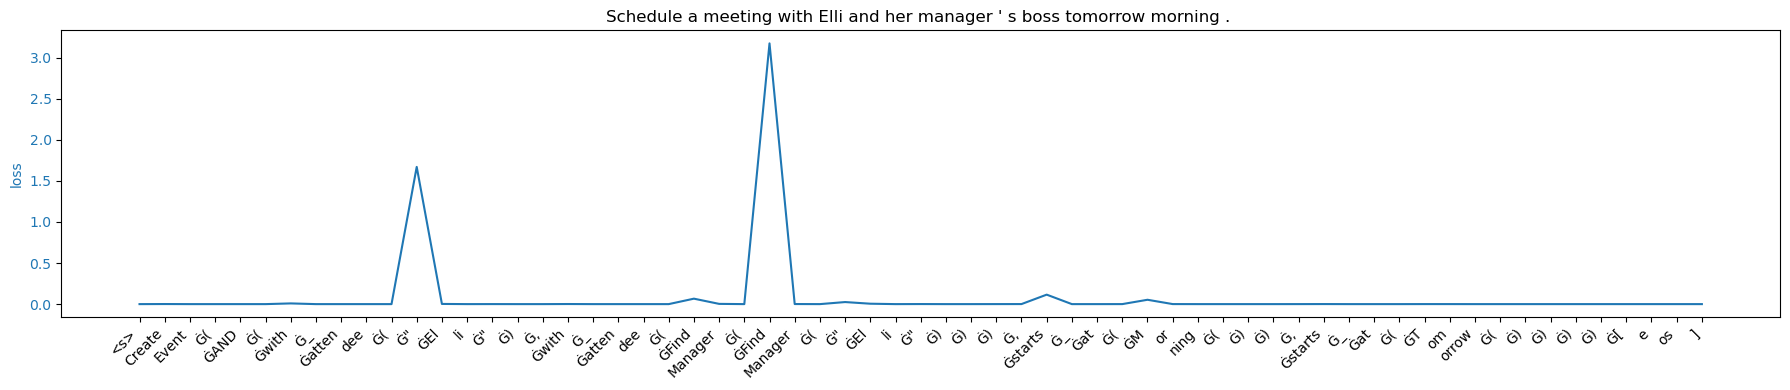

In [45]:
# plot_batch_and_metric(
#     tokenizer,
#     single_test_example,
#     single_test_example_shot_loss,
#     idx2word,
#     shot_harness.hparams.pad_token
# )

done


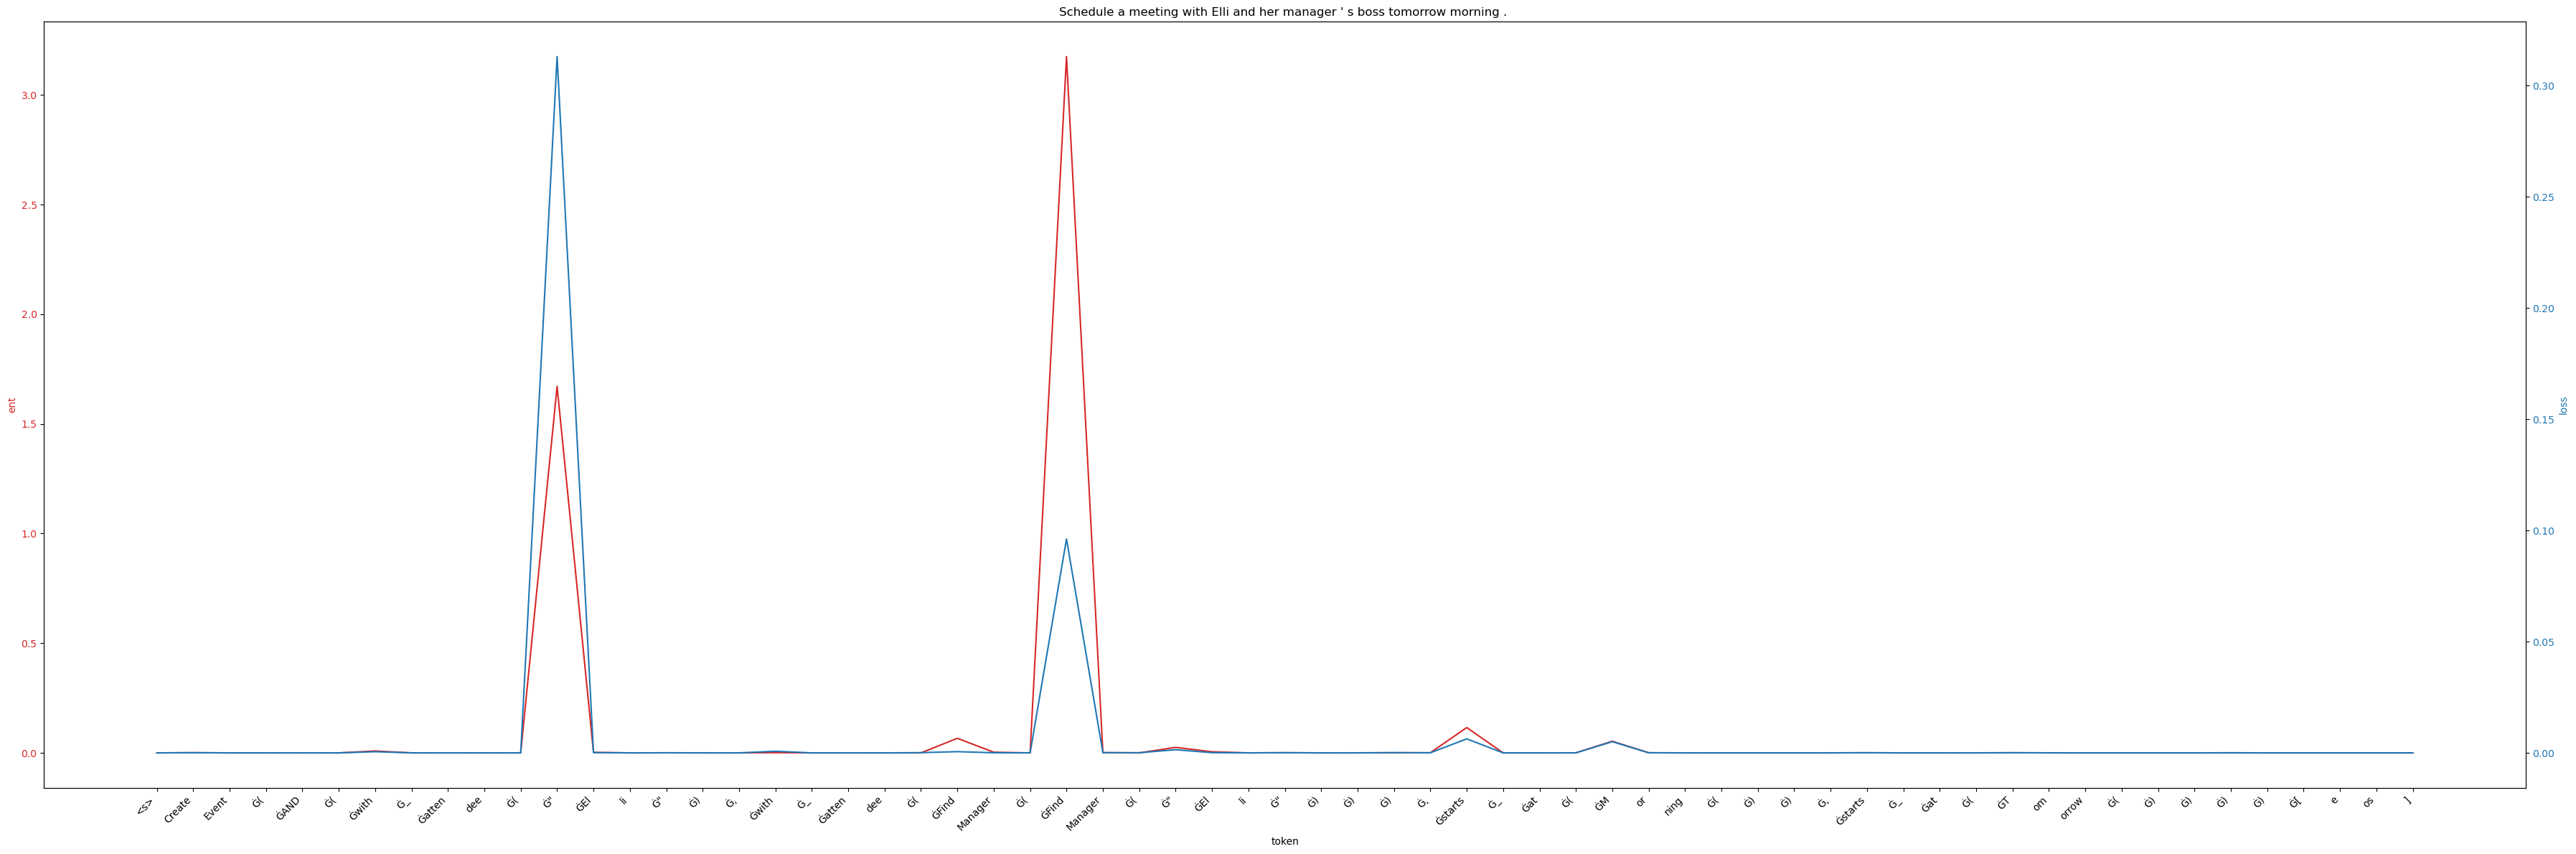

In [46]:
# plot_batch_and_metric_pair(
#     tokenizer,
#     single_test_example,
#     single_test_example_shot_loss,
#     single_test_example_student_teacher_divergence,
#     idx2word,
#     shot_harness.hparams.pad_token
# )

In [57]:
%pdb on

Automatic pdb calling has been turned ON


In [41]:
# # These are all of the options that get generated by the uncertainty search
# [
#     [
#         tokenizer.batch_decode(y, skip_special_tokens=True)
#         for y in x
#     ]
#     for x in
#     uncertainty_guided_search(
#         shot_harness,
#         single_test_example,
#         tokenizer,
#     )
# ]

[[["Schedule a meeting with Elli and her manager's boss tomorrow morning. ",
   'CreateEvent ( AND ( with _attendee ( " Elli " ), with _attendee ( FindManager ( " Elli " ) ), has _ subject ( FindManager ( " Elli " ) ), begins _ at ( Morning ( ) ), starts _ at ( Tomorrow ( ) ) ) ) [eos] [eos] FindManager ( FindManager ( " ELli " ) ) ) [eos] FindEvents ( AND ( starts _ at ( Morning ( ) ), starts _ at ( Tomorrow ( ) ) ) ) ) [eos] Find',
   'CreateEvent ( AND ( with _ attendee ( " Elli " ), with _ attendee ( FindManager ( FindManager ( " Elli " ) ) ), starts _ at ( Morning ( ) ), starts _ at ( Tomorrow ( ) ) ) ) [eos]'],
  ["Schedule a meeting with Elli and her manager's boss tomorrow morning. ",
   'CreateEvent ( AND ( with _attendee ( " Elli " ), with _attendee ( FindManager ( " Elli " ) ), has _ subject ( FindManager ( " Elli " ) ), begins _ at ( Morning ( ) ), starts _ at ( Tomorrow ( ) ) ) ) [eos] [eos] FindManager ( FindManager ( " ELli " ) ) ) [eos] FindEvents ( AND ( starts _ at ( 